# <div align="middle"><a href="https://analytics.sgmarkets.com" target="_blank"><img src="https://info.sgmarkets.com/static/media/sg-brand-en.e0f42696.svg" alt="Societe Generale" style="max-width: 50%; height: auto;"></a></div>

## If you like our Quant research, our Quant data, our Quant conferences, our Quant universities - please don't forget to vote for SG Quant by clicking the photo link below


## <div align="middle"><a href="https://voting.institutionalinvestor.com/welcome" target="_blank"><img src="https://content-cdn.sgmarkets.com/pictures/highlights/1deac76d-04f9-4f18-a6fa-7ce7cf6d2cb1_336x336" alt="II Survey" style="max-width: 50%; height: auto;"></a></div>


## This notebook is a tool to calculate theoretical backtests of a strategy called "Dynamic Put Ratio", and detailed in the research paper ["harvesting skew premium in equity options"](https://doc.sgmarkets.com/en/3/0/587265/289983.html?sid=efd96afbdce01ab7f6f727e05d81053d)
## This is a SG Quant research output, and not an investment proposal. Please refer to important disclaimers at the bottom of this page
## The backtests use options traded on an OTC format

## Import packages

In [1]:
from datetime import datetime as dt
import os
import matplotlib.pyplot as plt
import ast
import pandas as pd

import json
from src.backtest_types.db_series import DBSeries
from src.backtest_types.roll_options import RollOptions
from src.exceptions import BacktestFactoryException
from src.main import *

## inputs

In [2]:
# put option maturity choice
month_choice = '3m'

# option type choice
option_type = 'PUT'  # other possible input : 'CALL'

# put option delta strikes choice
long_delta_strike_choice = -0.05  # delta strikes should be negative if option_type is PUT, otherwise should be positive
short_delta_strike_choice = -0.10

# vega fees choice, on the short leg only
vega_fees = 0.3

# Backtest start and end dates are chosen based on available data, please see below

In [3]:
putratio_no_cost = f"Putratio_no_cost_{month_choice}"
putratio_with_cost = f"Putratio_cost_{month_choice}"

In [4]:
all_backtests = [putratio_with_cost]  # other possible inputs : [putratio_no_cost, putratio_with_cost]

## Results folder creation

In [5]:
config_path = 'src/input_configuration_deltastrike_fixed_notional.json'
new_dump_folder = os.path.abspath(os.path.join('.'))
for path_append in ['RESULTS', f"DeltaStrike_backtests Fixed notional_SPX Index"]:
    new_dump_folder = os.path.join(new_dump_folder, path_append)
    if not os.path.exists(new_dump_folder):
        os.mkdir(new_dump_folder)

## Check the configuration and run backtest

In [6]:
def pretty(d, indent=0, final_end="\n"):
    print()
    print('\t' * indent + '{', end="")
    all_keys = list(d.keys())
    for key in all_keys:
        value = d[key]
        if key == all_keys[0]:
            print(str(key), end=":")
        else:
            print('\t' * indent + str(key), end=":")
        if isinstance(value, dict):
            pretty(value, indent+1)
        elif isinstance(value, list):
            print("[")
            for x in value:
                pretty(x, indent+1, final_end=",")
            print("]")
        else:
            print(str(value), end=",\n")
    print('\t' * indent + '}', end=final_end)

dict_month_choice = {'1m': 20,
                     '3m': 60,
                     '6m': 125,
                     '9m': 185,
                     '1y': 250}

for backtest_name in all_backtests:

    with open(config_path) as config_file:
        content = config_file.read()
        try:
            dict_json = json.load(config_file)
        except (ValueError, TypeError):
            content = content.replace('true', 'True').replace('false', 'False')
            dict_json = ast.literal_eval(content)
        configuration = dict_json['Configurations'][0]['Index'] if 'Configurations' in dict_json else dict_json

    # Backtest start and end date will be based on available data
    volatilities_df = pd.read_hdf(os.path.abspath(os.path.join("Data_cache.h5")),
                                  key="implied_volatility_data").fillna(method='ffill')
    volatilities_df.columns = pd.MultiIndex.from_tuples(list(map(eval, volatilities_df.columns)))
    volatilities_df = volatilities_df
    configuration['Calendar']['LaunchDate'] = f'{volatilities_df.index[0].year + 1}-01-01'
    configuration['Calendar']['EndDate'] = volatilities_df.index[-1].strftime("%Y-%m-%d")

    if 'Putratio' in backtest_name:
        configuration['Parameters']['Groups'][0]['DeltaStrike'] = short_delta_strike_choice
        configuration['Parameters']['Groups'][1]['DeltaStrike'] = long_delta_strike_choice
        
        put_1_strike = int(configuration['Parameters']['Groups'][0]['DeltaStrike'] * 100)
        put_2_strike = int(configuration['Parameters']['Groups'][1]['DeltaStrike'] * 100)
        long_short_1 = configuration['Parameters']['Groups'][0]['LongShort'].lower()
        long_short_2 = configuration['Parameters']['Groups'][1]['LongShort'].lower()
        type_1 = configuration['Parameters']['Groups'][0]['Type']
        type_2 = configuration['Parameters']['Groups'][1]['Type']
        backtest_name += f"_{put_1_strike}d{long_short_1}{type_1}{put_2_strike}d{long_short_2}{type_2}"

    if 'no_cost' in backtest_name:
        configuration['Parameters']['Groups'][0]["VegaEntryFees"] = 0.
    else:
        configuration['Parameters']['Groups'][0]["VegaEntryFees"] = vega_fees
        
    if option_type == "CALL":
        config_groups = []
        for group_ in configuration['Parameters']['Groups']:
            group_["Type"] = option_type
            config_groups.append(group_)
        configuration['Parameters']['Groups'] = config_groups
    else:
        put_2_strike = int([x for x in configuration['Parameters']['Groups'] if x["VegaEntryFees"] > 0][0]['DeltaStrike'] * 100)
        put_2_fees = [x for x in configuration['Parameters']['Groups'] if x["VegaEntryFees"] > 0][0]['VegaEntryFees']
        backtest_name += f"_{put_2_fees}VegaFeesOn{put_2_strike}d"

    for group_ in configuration['Parameters']['Groups']:
        group_['NbOptions'] = dict_month_choice[month_choice]
        group_['NextMaturity'] = dict_month_choice[month_choice]

    with open(os.path.join(new_dump_folder, f'{backtest_name}.json'), 'w') as file:
        file.write(json.dumps(configuration))
        
    pretty(configuration)

    start = dt.now()
    bt = run_backtest(configuration)

    t = (dt.now() - start).total_seconds()
    print('%s seconds' % t)

    df_intermediate_res = bt.intermediate_results_dump()
    filename = f"{configuration['Underlyings'][0]['Index']['Name'].split(' ')[0]}_{backtest_name}"
    df_intermediate_res.to_pickle(os.path.join(new_dump_folder, f'{filename}.pkl'))
    df_intermediate_res = df_intermediate_res.reindex(columns=['IL'])

    df_intermediate_res.to_excel(os.path.join(new_dump_folder, f'{filename}.xlsx'), engine="openpyxl")


{Type:RollOptions,
Calendar:
	{LaunchDate:2001-01-01,
	EndDate:2023-04-10,
	Holidays:RINY,
	}
Parameters:
	{Groups:[

		{Type:PUT,
		Roll:
			{Frequency:DAILY,
			}
		NextMaturity:60,
		LongShort:SHORT,
		NominalType:FIXED,
		NbOptions:60,
		EntryType:PROGRESSIVE,
		Leverage:DPR_fixed_notional,
		VegaEntryFees:0.3,
		VegaExitFees:0,
		DeltaHedged:True,
		DeltaStrike:-0.1,
		WeightScheme:InverseDollarGamma_times_vol_impli_sq,
		Fwd_hedge:True,
		},
		{Type:PUT,
		Roll:
			{Frequency:DAILY,
			}
		NextMaturity:60,
		LongShort:LONG,
		NominalType:FIXED,
		NbOptions:60,
		EntryType:PROGRESSIVE,
		Leverage:DPR_fixed_notional,
		VegaEntryFees:0.0,
		VegaExitFees:0,
		DeltaHedged:True,
		DeltaStrike:-0.05,
		WeightScheme:InverseDollarGamma_times_vol_impli_sq,
		Fwd_hedge:True,
		},]
	Pricing:BlackScholes,
	}
Underlyings:[

	{Index:
		{Type:DBSeries,
		Name:SPX Index,
		}
	},
	{Index:
		{Type:DBSeries,
		Name:SGBVRES1 Index,
		}
	Parameters:
		{Tag:HEDGE,
		}
	},]
}
213.11319 seconds


C:\Users\amukhopa111915\PycharmProjects\Data + source code + conda env requirements\src\backtest_types\roll_options.py:1403: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  df_payoffs_deltas, df_vegas, df_volas, df_payoffs_vegas], axis=1, join_axes=[df.index])


## Read backtest dump and plot IL

In [7]:
list_of_all_pickles = [os.path.join(new_dump_folder, x) for x in os.listdir(new_dump_folder) if ('.pkl' in x) & ('~' not in x)]

In [8]:
df_intermediate_res = pd.read_pickle(list_of_all_pickles[0])

<AxesSubplot:ylabel='performance'>

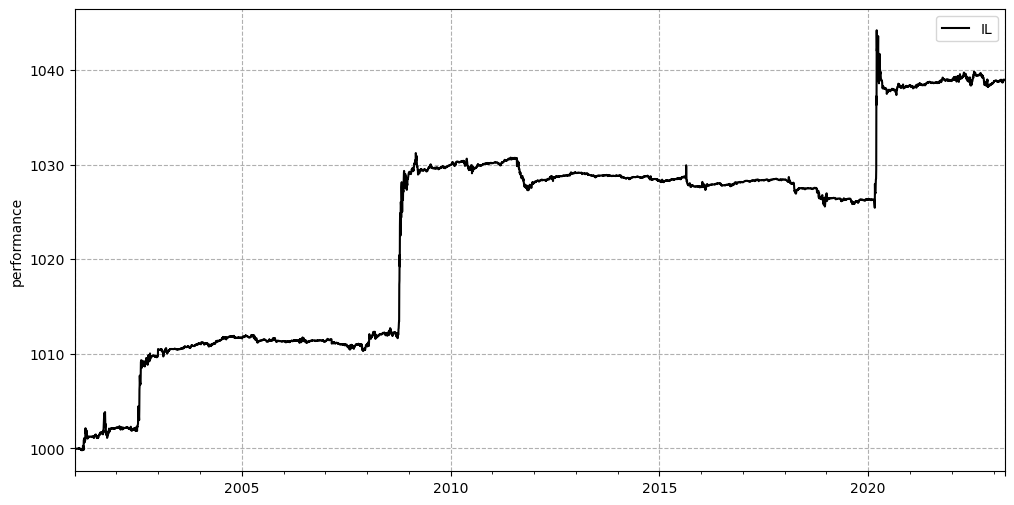

In [9]:
ax = plt.subplot()
ax.grid(linestyle='--')
ax.set_ylabel("performance")
df_intermediate_res["IL"].plot(grid=True, ax=ax, figsize=(12, 6), legend=True, color='black')

## Read backtest dump and plot performance attribution

### Performance attribution as described in the paper ["Harvesting skew premium in equity options"](https://doc.sgmarkets.com/en/3/0/587265/289983.html?sid=efd96afbdce01ab7f6f727e05d81053d)

In [10]:
df_perf_attribution = pd.DataFrame(index=df_intermediate_res.index)
df_perf_attribution.loc[:, "Gamma PnL"] = df_intermediate_res.loc[:, [x for x in df_intermediate_res.columns if x.split(' ')[0] in ['vol_premium_component', 'gamma_covariance_effect']]].sum(axis=1)
df_perf_attribution.loc[:, "Vega PnL"] = df_intermediate_res.loc[:, [x for x in df_intermediate_res.columns if x.split(' ')[0] in ['vega_term']]].sum(axis=1)
df_perf_attribution.loc[:, "Sum of gamma noise and residual drift"] = df_intermediate_res.loc[:, [x for x in df_intermediate_res.columns if x.split(' ')[0] in ['d_gamma_term', 'residual_drift_term']]].sum(axis=1)

<AxesSubplot:ylabel='performance attribution'>

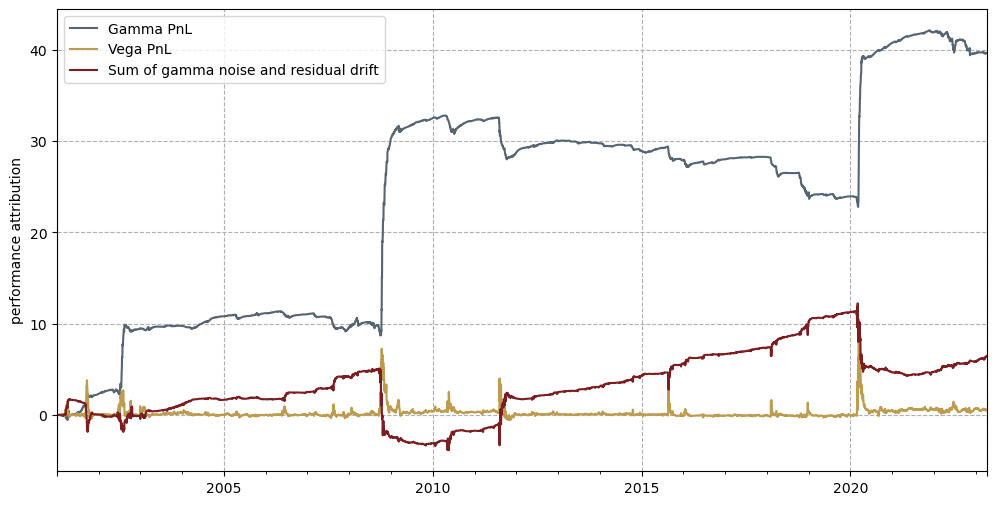

In [11]:
ax = plt.subplot()
ax.grid(linestyle='--')
ax.set_ylabel("performance attribution")
df_perf_attribution.plot(grid=True, ax=ax, figsize=(12, 6), legend=True, color=['#566573', '#BD9C4F', '#7B1D21'])

## Disclaimer

ANALYST CERTIFICATION
Each author of this research report listed on the cover hereby certifies that the views expressed in the research report accurately reflect his or her personal views, including views about subject securities or issuers mentioned in the report, if any.  No part of his or her compensation was, is or will be related, directly or indirectly to the specific recommendations or views expressed in this report. 

The analyst(s) who author research are employed by SG and its affiliates in locations, including but not limited to, Paris, London, New York, Hong Kong, Tokyo, Bangalore, Frankfurt, Madrid, Milan, Geneva, Seoul, Warsaw, Moscow and Casablanca.

CONFLICTS OF INTEREST
This research contains the views, opinions and recommendations of Societe Generale (SG) credit research analysts and/or strategists.  To the extent that this research contains trade ideas based on macro views of economic market conditions or relative value, it may differ from the fundamental credit opinions and recommendations contained in credit sector or company research reports and from the views and opinions of other departments of SG and its affiliates.  Credit research analysts and/or strategists routinely consult with SG sales and trading desk personnel regarding market information including, but not limited to, pricing, spread levels and trading activity of a specific fixed income security or financial instrument, sector or other asset class. Trading desks may trade, or have traded, as principal on the basis of the research analyst(s) views and reports.
As a general matter, SG and/or its affiliates normally make a market and trade as principal in fixed income securities discussed in research reports. SG has mandatory research policies and procedures that are reasonably designed to (i) ensure that purported facts in research reports are based on reliable information and (ii) to prevent improper selective or tiered dissemination of research reports. In addition, research analysts receive compensation based, in part, on the quality and accuracy of their analysis, client feedback, competitive factors and SG’s total revenues including revenues from sales and trading and investment banking.

IMPORTANT NOTICE: Sections of this publication that are contributed by non-independent analysts should not be construed as investment research as such have not been prepared in accordance with legal requirements designed to promote the independence of investment research. Therefore, even if such sections contain a research recommendation, such sections should be treated as a marketing communication and not as investment research. SG is required to have policies in place to manage the conflicts which may arise in the production of its research, including preventing dealing ahead of investment research.

IMPORTANT DISCLAIMER:  The information herein is not intended to be an offer to buy or sell, or a solicitation of an offer to buy or sell, any securities and has been obtained from, or is based upon, sources believed to be reliable but is not guaranteed as to accuracy or completeness. Material contained in this report satisfies the regulatory provisions concerning independent investment research as defined in MiFID. Information concerning conflicts of interest and SG’s management of such conflicts is contained in the SG’s Policies for Managing Conflicts of Interests in Connection with Investment Research which is available at https://insight.sgmarkets.com/compliance/equity SG does, from time to time, deal, trade in, profit from, hold, act as market-makers or advisers, brokers or bankers in relation to the securities, or derivatives thereof, of persons, firms or entities mentioned in this document and may be represented on the board of such persons, firms or entities. SG does, from time to time, act as a principal trader in equities or debt securities that may be referred to in this report and may hold equity or debt securities positions or related derivatives. Employees of SG, or individuals connected to them, may from time to time have a position in or hold any of the investments or related investments mentioned in this document. SG is under no obligation to disclose or take account of this document when advising or dealing with or on behalf of customers. The views of SG reflected in this document may change without notice. In addition, SG may issue other reports that are inconsistent with, and reach different conclusions from, the information presented in this report and is under no obligation to ensure that such other reports are brought to the attention of any recipient of this report. To the maximum extent possible at law, SG does not accept any liability whatsoever arising from the use of the material or information contained herein. This research document is not intended for use by or targeted to retail customers. Should a retail customer obtain a copy of this report he/she should not base his/her investment decisions solely on the basis of this document and must seek independent financial advice.

The financial instruments discussed in this report may not be suitable for all investors and investors must make their own informed decisions and seek their own advice regarding the appropriateness of investing in financial instruments or implementing strategies discussed herein. The value of securities and financial instruments is subject to currency exchange rate fluctuation that may have a positive or negative effect on the price of such securities or financial instruments, and investors in securities such as ADRs effectively assume this risk. SG does not provide any tax advice. Past performance is not necessarily a guide to future performance. Estimates of future performance are based on assumptions that may not be realized. Investments in general, and derivatives in particular, involve numerous risks, including, among others, market, counterparty default and liquidity risk. Trading in options involves additional risks and is not suitable for all investors. An option may become worthless by its expiration date, as it is a depreciating asset. Option ownership could result in significant loss or gain, especially for options of unhedged positions. Prior to buying or selling an option, investors must review the "Characteristics and Risks of Standardized Options" at http://www.optionsclearing.com/about/publications/character-risks.jsp or from your SG representative. Analysis of option trading strategies does not consider the cost of commissions. Supporting documentation for options trading strategies is available upon request.

Notice to French Investors: This publication is issued in France by or through Société Générale ("SG") which is authorised and supervised by the Autorité de Contrôle Prudentiel et de Résolution (ACPR) and regulated by the Autorité des Marchés Financiers (AMF).
Notice to U.K. Investors: Société Générale is a French credit institution (bank) authorised by the Autorité de Contrôle Prudentiel (the French Prudential Control Authority) and the Prudential Regulation Authority and subject to limited regulation by the Financial Conduct Authority and Prudential Regulation Authority. Details about the extent of our authorisation and regulation by the Prudential Regulation Authority, and regulation by the Financial Conduct Authority are available from us on request.
Notice to Swiss Investors: This document is provided in Switzerland by or through Société Générale Paris, Zürich Branch, and is provided only to qualified investors as defined in article 10 of the Swiss Collective Investment Scheme Act (“CISA”) and related provisions of the Collective Investment Scheme Ordinance and in strict compliance with applicable Swiss law and regulations. The products mentioned in this document may not be suitable for all types of investors. This document is based on the Directives on the Independence of Financial Research issued by the Swiss Bankers Association (SBA) in January 2008.
Notice to Polish Investors: this document has been issued in Poland by Societe Generale S.A. Oddzial w Polsce (“the Branch”) with its registered office in Warsaw (Poland) at 111 Marszałkowska St. The Branch is supervised by the Polish Financial Supervision Authority and the French ”Autorité de Contrôle Prudentiel”. This report is addressed to financial institutions only, as defined in the Act on trading in financial instruments. The Branch certifies that this document has been elaborated with due dilligence and care.
Notice to U.S. Investors: For purposes of SEC Rule 15a-6, SG Americas Securities LLC (“SGAS”) takes responsibility for this research report. This report is intended for institutional investors only. Any U.S. person wishing to discuss this report or effect transactions in any security discussed herein should do so with or through SGAS, a U.S. registered broker-dealer and futures commission merchant (FCM). SGAS is a member of FINRA, NYSE and NFA. Its registered address at 245 Park Avenue, New York, NY, 10167. (212)-278-6000.
Notice to Canadian Investors: This document is for information purposes only and is intended for use by Permitted Clients, as defined under National Instrument 31-103, Accredited Investors, as defined under National Instrument 45-106, Accredited Counterparties as defined under the Derivatives Act (Québec) and "Qualified Parties" as defined under the ASC, BCSC, SFSC and NBSC Orders
Notice to Singapore Investors: This document is provided in Singapore by or through Société Générale ("SG"), Singapore Branch and is provided only to accredited investors, expert investors and institutional investors, as defined in Section 4A of the Securities and Futures Act, Cap. 289. Recipients of this document are to contact Société Générale, Singapore Branch in respect of any matters arising from, or in connection with, the document. If you are an accredited investor or expert investor, please be informed that in SG's dealings with you, SG is relying on the following exemptions to the Financial Advisers Act, Cap. 110 (“FAA”): (1) the exemption in Regulation 33 of the Financial Advisers Regulations (“FAR”), which exempts SG from complying with Section 25 of the FAA on disclosure of product information to clients; (2) the exemption set out in Regulation 34 of the FAR, which exempts SG from complying with Section 27 of the FAA on recommendations; and (3) the exemption set out in Regulation 35 of the FAR, which exempts SG from complying with Section 36 of the FAA on disclosure of certain interests in securities.
Notice to Hong Kong Investors: This report is distributed or circulated in Hong Kong only to “professional investors” as defined in the Securities and Futures Ordinance (Chapter 571 of the Laws of Hong Kong) (“SFO”). Any such professional investor wishing to discuss this report or take any action in connection with it should contact SG Securities (HK) Limited. This report does not constitute a solicitation or an offer of securities or an invitation to the public within the meaning of the SFO.
Notice to Japanese Investors: This publication is distributed in Japan by Societe Generale Securities Japan Limited, which is regulated by the Financial Services Agency of Japan. This document is intended only for the Specified Investors, as defined by the Financial Instruments and Exchange Law in Japan and only for those people to whom it is sent directly by Societe Generale Securities Japan Limited, and under no circumstances should it be forwarded to any third party. The products mentioned in this report may not be eligible for sale in Japan and they may not be suitable for all types of investors.
Notice to Korean Investors: This report is distributed in Korea by SG Securities Korea Co., Ltd which is regulated by the Financial Supervisory Service and the Financial Services Commission.
For Documents distributed In Australia by SG Securities (HK) Limited - Notice to Australian Investors: For Documents Distributed in Australia by SG Securities (HK) Limited: This document is distributed by SG Securities (HK) Limited, a Registered Foreign Company and Foreign Financial Services Provider in Australia (ARBN 126058688) that is exempt from the requirement to hold an Australian financial services licence under the Corporations Act 2001 (“Act”). SG Securities (HK) Limited is regulated by the Securities and Futures Commission under Hong Kong laws, which differ from Australian laws. The information contained in this document is only directed to recipients who are wholesale clients as defined under the Act.
For Documents Distributed in Australia by SG Sydney Branch - Notice to Australian investors: This document is distributed by Société Générale (ABN 71 092 516 286). Société Générale holds an AFSL no. 511956 issued under the Corporations Act 2001 (Cth) (“Act”). Société Générale is a foreign Authorised Deposit-Taking Institution under the Banking Act 1959 (Cth) and any products described in this document which are issued by Société Générale do not form deposits or other funds of Société Générale. No entity described in this document (aside from Société Générale) is an Authorised Deposit-Taking Institution and the transactions which may be proposed and products which may be issued as described in this document do not form deposits or other funds of Société Générale. Unless this document expressly provides that Société Générale will provide a guarantee, Société Générale does not guarantee the obligations of any other entity described in this document in respect of any proposed transactions or products and those obligations do not represent liabilities of Société Générale. This document is provided to you on the basis that you are a 'wholesale client' within the meaning of section 761G of the Act.
Notice to Indian Investors: Societe Generale Global Solution Center Pvt. Ltd (SG GSC) is a 100% owned subsidiary of Societe Generale, SA, Paris. Societe Generale SA which is authorised and supervised by the Autorité de Contrôle Prudentiel et de Résolution (ACPR) and regulated by the Autorité des Marchés Financiers (AMF). Analysts employed by SG GSC do not produce research covering securities listed on any stock exchange recognised by the Securities and Exchange Board of India (SEBI) and is not licensed by either SEBI or the Reserve Bank of India.
For Recipients in Thailand receiving this document from offshore: This document has been distributed by SG solely at your request. This document is not intended to be either an offer, sale, or invitation for subscription or purchase of the securities or any regulated financial services in Thailand. Neither SG, any representatives, directors, employees of SG nor any other entities affiliated with SG make any representations or warranties, expressed or implied, with respect to the completeness or accuracy of any of the information contained in this document or any other information (whether communicated in written or oral form) transferred or made available to you.

http://www.sgcib.com. Copyright: The Société Générale Group 2023. All rights reserved.
This publication may not be reproduced or redistributed in whole in part without the prior consent of SG or its affiliates.